In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from models import *

## Load data to fit "ground truth" curves

In [2]:
bat_dict = pickle.load(open(r'../Data/bat_dict_small.pkl', 'rb'))

In [3]:
def func(x, a, b, c):
    #return np.exp(a/temps)*x**b + c
    return np.exp(a)*x**b + c

In [86]:
params = []
cycle_lives = []
for id in bat_dict.keys():
    bat = bat_dict[id]
    #temps = np.mean(bat['summary']['Tavg'][1:cutoff])+273
    Y = 1-bat['summary']['QD'][1:100]/1.1
    length = len(bat['summary']['QD'][1:100])
    x = np.arange(1,length+1)
    
    def parameter_estimation_function(x):
        return np.asarray(Y) - func(x=np.arange(1,len(Y)+1), a=x[0],b=x[1],c=x[2])
    
    param = least_squares(parameter_estimation_function, [-30,3,0.02], bounds=([-50,2,0.01],[-10,4,0.03]), max_nfev = 4000)

    alpha = param.x[0]
    beta = param.x[1]
    gamma = param.x[2]
    params.append([alpha,beta,gamma])
    
    cycle_lives.append(bat["cycle_life"][0])
params = np.array(params)
cycle_lives = np.array(cycle_lives)

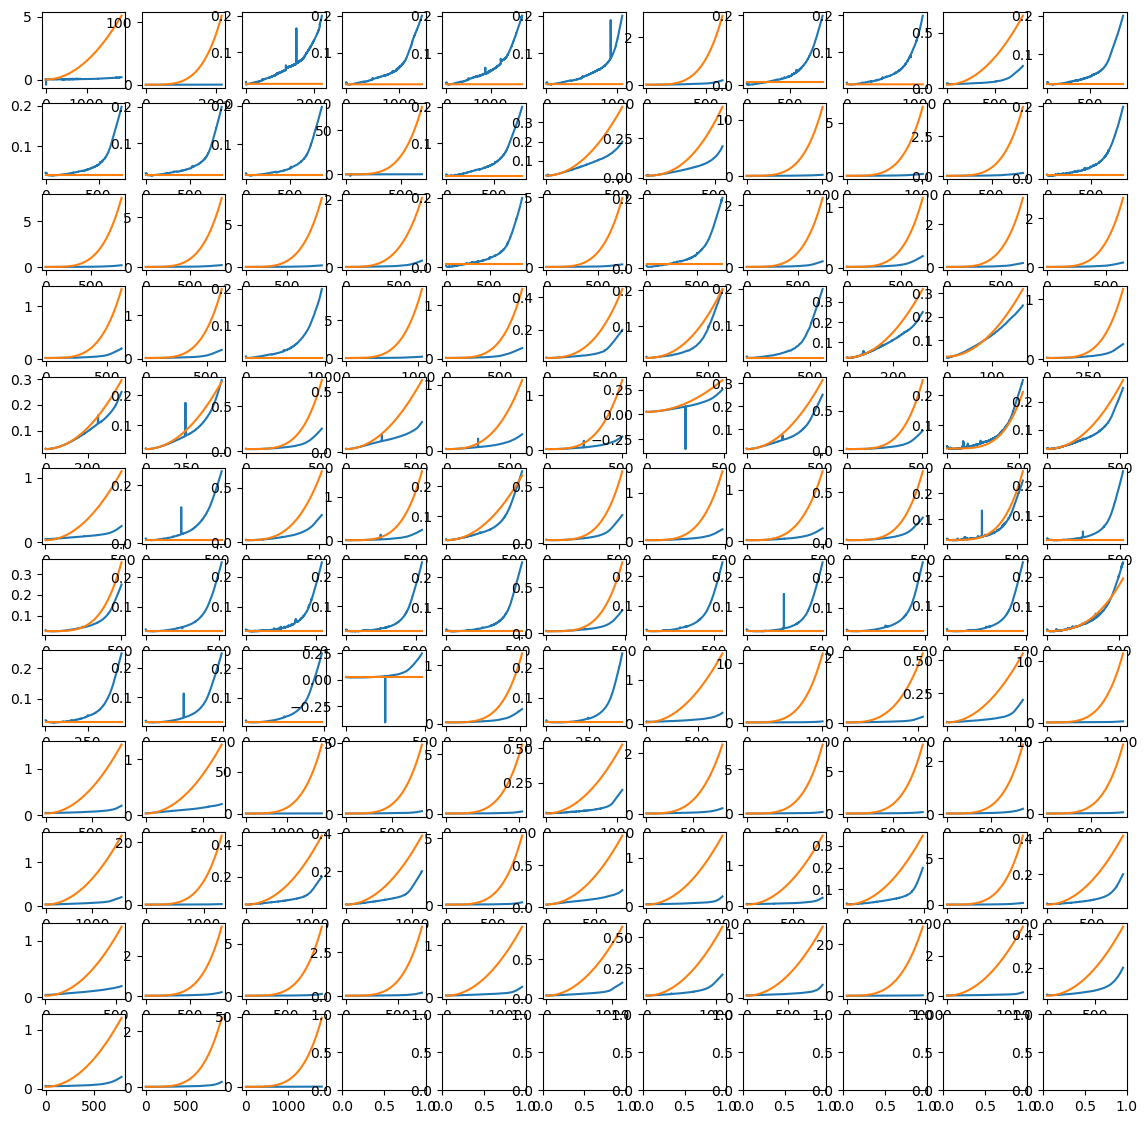

In [87]:
# visualize curve fits
fig,axs=plt.subplots(nrows=12,ncols=11,figsize=(14,14))
for ix,id in enumerate(bat_dict.keys()):
    ax = axs[int(ix/11)][ix%11]
    length = len(bat_dict[id]['summary']['QD'][1:])
    x = np.arange(1,length+1)
    Y = 1-bat_dict[id]['summary']['QD'][1:]/1.1
    ax.plot(x, Y)

    alpha = params[ix][0]
    beta = params[ix][1]
    gamma = params[ix][2]
    ax.plot(x, func(x,alpha,beta,gamma), linestyle="-")

In [88]:
def analytic_cycle_life(params):
    a, b, c = params
    return np.power(np.exp(-a)*(0.2-c),1/b)

def counting_cycle_life(params):
    a, b, c = params
    x = np.arange(1, 2500)
    curve = np.exp(a)*np.power(x, b) + c
    return np.sum(curve < 0.2)

b1c0	355.73672722993877	355	1852.0
b1c1	435.87380800410904	435	2160.0
b1c2	19052571.33597454	2499	2237.0
b1c3	23047985.06635534	2499	1434.0
b1c4	9934246.878221681	2499	1709.0
b1c5	68810103.69252355	2499	1074.0
b1c6	318.37315237317137	318	636.0
b1c7	28859170.107052073	2499	870.0
b1c9	151463041.91160187	2499	1054.0
b1c11	410.62208389067956	410	788.0
b1c14	30347431160.94579	2499	880.0
b1c15	282474.3197292173	2499	719.0
b1c16	79797031.17173573	2499	862.0
b1c17	30444619277.901398	2499	857.0
b1c18	153.16337003699215	153	691.0
b1c19	63966999.1424257	2499	788.0
b1c20	374.2252818516461	374	534.0
b1c21	387.48919262149747	387	559.0
b1c23	354.2474072352833	354	1014.0
b1c24	414.5839674831619	414	1017.0
b1c25	385.05605442534164	385	854.0
b1c26	312569891.36695415	2499	870.0
b1c27	330.4286368921852	330	842.0
b1c28	346.239858956227	346	860.0
b1c29	355.3689314632423	355	917.0
b1c30	358.35313405456463	358	709.0
b1c31	25149750.998617668	2499	876.0
b1c32	319.2111107414027	319	731.0
b1c33	18055204.354778867

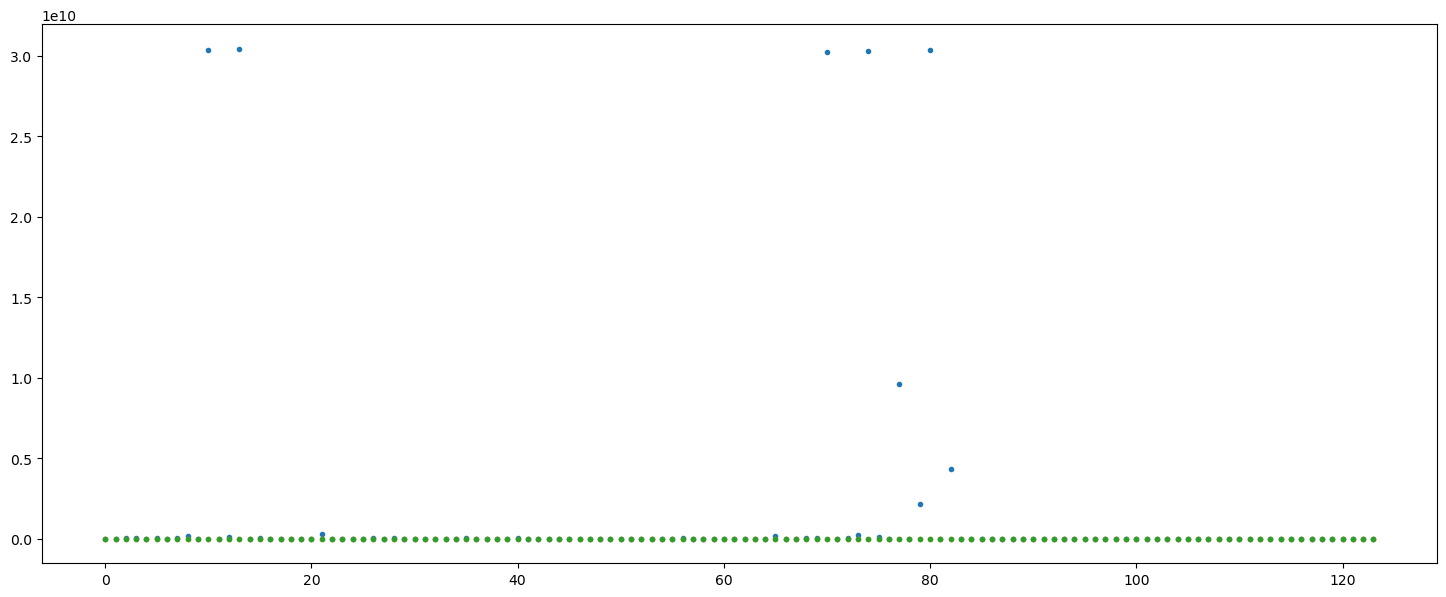

In [89]:
cls1 = []
cls2 = []
cls_true = []
for ix,id in enumerate(bat_dict.keys()):
    cl1 = analytic_cycle_life(params[ix])
    cl2 = counting_cycle_life(params[ix])
    cl_true = bat_dict[id]["cycle_life"].item()
    print(id, cl1, cl2, cl_true, sep = "\t")
    for cl, list in zip([cl1, cl2, cl_true], [cls1, cls2, cls_true]):
        list.append(cl)
plt.plot(cls1, ".")
plt.plot(cls2, ".")
plt.plot(cls_true, ".")
print(np.mean(np.abs(np.array(cls1) - np.array(cls2))))
print(np.mean(np.abs(np.array(cls1) - np.array(cls_true))))

## Load data for predictive model

In [411]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122])

In [412]:
data = pickle.load(open(r'../Data/sev_deltaQ_cycles.pkl', 'rb'))
n_cycles = 98
cut_start = 0

features = [
    "DeltaQ_logVars",
    "DeltaQ_mins",
    # "DeltaQ_means",
    # "DeltaT_max",
    "DeltaT_logVars",
]

n_cycles = n_cycles - cut_start
y = np.zeros(124)
x = np.zeros((124, n_cycles*len(features)))

for i, cell in enumerate(data.keys()):
    for j, feature in enumerate(features):
        x[i, j*n_cycles:(j+1)*n_cycles] = data[cell][feature][cut_start:n_cycles]
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(params[train_ind]))
test = TensorDataset(torch.Tensor(x[test_ind]),torch.Tensor(params[test_ind]))
stest = TensorDataset(torch.Tensor(x[secondary_ind]),torch.Tensor(params[secondary_ind]))

In [413]:
class AutoEncoder_ElasticNet(nn.Module):
    def __init__(self, n_features, n_cycles=49, alpha=0.5):
        super(AutoEncoder_ElasticNet, self).__init__()

        self.alpha = alpha
        self.n_features = n_features
        self.n_cycles = n_cycles

        self.encoder = nn.Sequential(
            nn.Linear(n_features*n_cycles, n_features*32),
            nn.ReLU(),
            nn.Linear(n_features*32, n_features*16),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(n_features*16, n_features*32),
            nn.ReLU(),
            nn.Linear(n_features*32, n_features*n_cycles)
        )

        self.prediction = nn.Linear(n_features*16, 1)

    def prediction_loss(self):
        l1_norm = self.prediction.weight.abs().sum()
        l2_norm = self.prediction.weight.pow(2).sum()
        return (1-self.alpha)/2 * l2_norm + self.alpha * l1_norm
    
    def predict(self, x):
        self.eval()
        return self.prediction(self.encoder(x))
    
    def forward(self, x):
        self.eval()
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def evaluate(self, x, y):
        mses = [0.0, 0.0, 0.0]
        for i in train_ind:
            mses[0] += (10**self.predict(x[i].expand((1, *x[i].size()))).detach().numpy() - 10**y[i].detach().numpy())**2
        for i in test_ind:
            mses[1] += (10**self.predict(x[i].expand((1, *x[i].size()))).detach().numpy() - 10**y[i].detach().numpy())**2
        for i in secondary_ind:
            mses[2] += (10**self.predict(x[i].expand((1, *x[i].size()))).detach().numpy() - 10**y[i].detach().numpy())**2

        mses[0] = np.sqrt(mses[0] / len(train_ind))
        mses[1] = np.sqrt(mses[1] / len(test_ind))
        mses[2] = np.sqrt(mses[2] / len(secondary_ind))

        for mse, label in zip(mses, ["\ntrain", "test", "sec"]):
            print(label, "\t", mse[0])

    def plotter(self, x, y, id):
        fig, axs = plt.subplots(1, 2)

        for i in range(self.n_features):
            axs[0].plot(x[id].detach().numpy()[i*self.n_cycles:(i+1)*self.n_cycles], 
                        self.forward(x[id]).detach().numpy()[i*self.n_cycles:(i+1)*self.n_cycles], "o", label = "feature {}".format(i+1))
        axs[0].plot(np.linspace(-5.5, 1.5, 3), np.linspace(-5.5, 1.5, 3), "k", alpha = 0.5)

        axs[0].legend(fontsize = 14)
        axs[0].set_xlabel("True input", fontsize = 16)
        axs[0].set_ylabel("Decoded input", fontsize = 16)
        axs[0].tick_params(axis='x', labelsize=14)
        axs[0].tick_params(axis='y', labelsize=14)
        axs[0].set_title("Decoder performance, cell "+str(id), fontsize = 20)

        axs[1].plot(10**y[train_ind], 10**self.predict(x[train_ind]).detach().numpy(), "o", label = "train")
        axs[1].plot(10**y[test_ind], 10**self.predict(x[test_ind]).detach().numpy(), "o", label = "test")
        axs[1].plot(10**y[secondary_ind], 10**self.predict(x[secondary_ind]).detach().numpy(), "o", label = "secondary")
        axs[1].plot(np.linspace(200, 2400, 3), np.linspace(200, 2400, 3), "k", alpha = 0.5)

        axs[1].legend(fontsize = 14)
        axs[1].set_xlabel("True lifetime", fontsize = 16)
        axs[1].tick_params(axis='x', labelsize=14)
        axs[1].tick_params(axis='y', labelsize=14)
        axs[1].set_ylabel("Predicted lifetime", fontsize = 16)
        axs[1].set_title("Prediction performance", fontsize = 20)

        plt.show()

    def fit(self, x, y, train_policy, verbose = True, plots = True, log_loss = False):

        self.train()
        loss_function = nn.MSELoss()
        train_data = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))

        num_stages = train_policy["num_stages"]
        for stage in range(num_stages):
            if verbose: print("Stage {}:\n".format(stage+1))

            epochs = train_policy["epochs"][stage]
            lr = train_policy["learning_rates"][stage]
            batch_size = train_policy["batch_sizes"][stage]
            prediction_weight = train_policy["prediction_weights"][stage]
            decoding_weight = train_policy["decoding_weights"][stage]
            en_weight = train_policy["decoding_weights"][stage]

            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            optimiser = torch.optim.Adam(self.parameters(), lr=lr)

            for ep in range(epochs):
                for batch in train_loader:
                    train_inputs, train_labels = batch
                    # train_inputs = train_inputs + torch.normal(mean=0,std=1,size=(train_inputs.size()[0], train_inputs.size()[1]))
                    outputs = self.forward(train_inputs)
                    predictions = self.predict(train_inputs)

                    if log_loss: prediction_loss = loss_function(train_labels, predictions[:, 0])
                    else: prediction_loss = loss_function(10**train_labels, 10**predictions[:, 0])
                    decoding_loss = loss_function(train_inputs, outputs)
                    en_loss = self.prediction_loss()
                    loss = en_loss*en_weight + decoding_loss*decoding_weight + prediction_loss*prediction_weight

                    optimiser.zero_grad()
                    loss.backward()
                    optimiser.step()

                if verbose:    
                    if (ep+1) % int(epochs / 10) == 0: print(f"Epoch {ep+1}/{epochs},   \tdecoding loss: {decoding_loss.item():.2f},    \tprediction loss: {prediction_loss.item():.2f},  \treg_loss: {en_loss.item():.2f}")

            if verbose: self.evaluate(x, y)
            if plots: self.plotter(x, y, 30)
                
class AttentionModel(torch.nn.Module):
    def __init__(self, d_model, feat_dim, n_cycle, vdim=1, num_heads=1, attn_model="softmax", beta=1, skip_connect=0):
        super(AttentionModel, self).__init__()
        '''d_model: embedding dimension; can be chosen independently of input data dimensions
           feat_dim: number of features in a cycle
           n_cycle: number of "cycles" outputted by the encoder / number of tokens, each of which has feat_dim features
           vdim: dimension of output, 1 for our regression problem
           num_heads: default 1
           attn_model: default softmax; code also supports batch normalized attention with keyword "batch_norm"
           beta: if using batch normalized attention, beta is the weight placed on the mean
           skip_connect: whether or not to add a skip connection. If 0, no skip connection. If 1, H=AV+B where B
           is a trainable projection of the input X. If 2, H=AV+V'''
        assert d_model % num_heads == 0, "Embedding dimension (d_model) must be divisible by number of attention heads (num_heads)."
        
        self.W_q = nn.Linear(feat_dim, d_model)
        self.W_k = nn.Linear(feat_dim, d_model)
        self.W_v = nn.Linear(feat_dim, vdim)
        self.W_b = nn.Linear(feat_dim, vdim)

        #self.create_output = nn.Linear(n_cycle,1) # final linear layer to collapse output

        self.d_model = d_model
        self.vdim = vdim
        self.num_heads = num_heads
        #self.head_dim = d_model // num_heads
        
        self.attn_model = attn_model
        self.beta = beta
        self.skip_connect = skip_connect

    def scaled_dot_product_attention(self, Q, K, V, B): 
        '''softmax attention'''
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model // self.num_heads)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, n_cycle, n_cycle)
        output = torch.matmul(attn_probs, V) # dimensionality (batch size, n_cycle, vdim)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def batch_normalized_attention(self, Q, K, V, B):
        '''batch normalized attention'''
        mu = torch.mean(K,0)
        s = torch.std(K,0,correction=0)
        attn_scores = torch.matmul(torch.mul(Q-self.beta*mu,s), torch.mul(K-self.beta*mu,s).transpose(-2,-1)) / math.sqrt(self.d_model)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, batch size)
        output = torch.matmul(attn_probs, V)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def forward(self, X):
        if len(X.size()) < 3:
            X = X[...,None] # add a feature dimension if there is none
        Q = self.W_q(X) # create query matrix, dimensionality (batch size, n_cycle, d_model)
        K = self.W_k(X) # create key matrix, dimensionality (batch size, n_cycle, d_model)
        V = self.W_v(X) # create value matrix, dimensionality (batch size, n_cycle, vdim)
        B = self.W_b(X) # create matrix for skip connection, dimensionality (batch size, n_cycle, vdim)

        # replaced final linear layer with just an averaging layer (gave better results earlier, can try putting linear layer back) 
        if self.attn_model=="softmax": attn_output = self.scaled_dot_product_attention(Q, K, V, B)
        elif self.attn_model=="batch_norm": attn_output = self.batch_normalized_attention(Q, K, V, B)
        # attn_output has dimensionality (batch_size, n_cycle, vdim)
        output = torch.mean(attn_output.transpose(-2,-1),dim=-1) # dimensionality (batch_size, vdim)
        #output = self.create_output(attn_output.transpose(-2,-1)) # dimensionality (batch size, 1, 1)
        return output

Stage 1:

Epoch 250/2500,   	decoding loss: 0.13,    	prediction loss: 556656.81,  	reg_loss: 1.76
Epoch 500/2500,   	decoding loss: 0.06,    	prediction loss: 556196.50,  	reg_loss: 1.22
Epoch 750/2500,   	decoding loss: 0.04,    	prediction loss: 555254.00,  	reg_loss: 0.84
Epoch 1000/2500,   	decoding loss: 0.03,    	prediction loss: 553589.06,  	reg_loss: 0.56
Epoch 1250/2500,   	decoding loss: 0.03,    	prediction loss: 550613.88,  	reg_loss: 0.39
Epoch 1500/2500,   	decoding loss: 0.03,    	prediction loss: 545098.25,  	reg_loss: 0.26
Epoch 1750/2500,   	decoding loss: 0.03,    	prediction loss: 534730.00,  	reg_loss: 0.14
Epoch 2000/2500,   	decoding loss: 0.02,    	prediction loss: 513654.59,  	reg_loss: 0.04
Epoch 2250/2500,   	decoding loss: 0.02,    	prediction loss: 104057.94,  	reg_loss: 0.32
Epoch 2500/2500,   	decoding loss: 0.03,    	prediction loss: 49718.53,  	reg_loss: 0.21

train 	 [221.61145]
test 	 [269.2319]
sec 	 [289.87823]


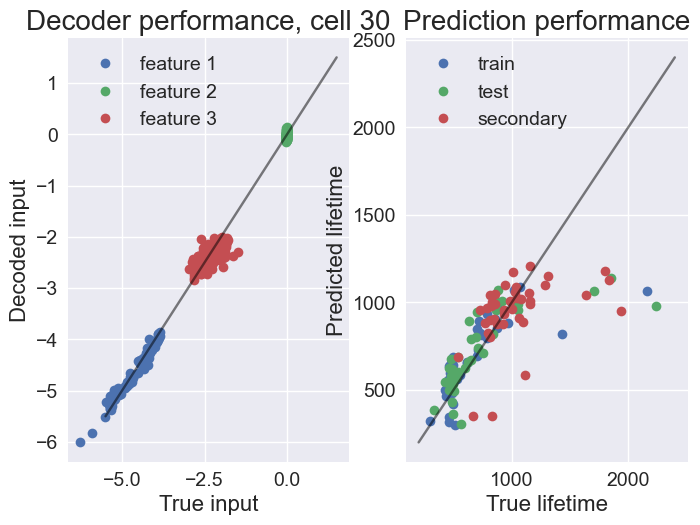

In [414]:
train_policy = {
    "num_stages": 1,
    "epochs": [2500],
    "learning_rates": [5e-4],
    "batch_sizes": [64, 64],
    "prediction_weights": [1/5000],
    "decoding_weights": [50],
    "en_weights": [50]
}


model = AutoEncoder_Attention(n_features=len(features), n_cycles=n_cycles, attention_embedding=4)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(x,y, train_policy)

In [415]:
x_train = model.encoder(x[train_ind]).detach().numpy()
x_test = model.encoder(x[test_ind]).detach().numpy()
x_stest = model.encoder(x[secondary_ind]).detach().numpy()

y_train = params[train_ind]
y_test = params[test_ind]
y_stest = params[secondary_ind]

life_train = cycle_lives[train_ind]
life_test = cycle_lives[test_ind]
life_stest = cycle_lives[secondary_ind]

train = TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train),torch.Tensor(life_train))
test = TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test),torch.Tensor(life_test))
stest = TensorDataset(torch.Tensor(x_stest),torch.Tensor(y_stest),torch.Tensor(life_stest))

In [416]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## First round of training (calc loss w/ model parameters)

In [434]:
d_model = 2
feat_dim = 1
n_cycle = np.shape(x_train)[1]
attn_model = "softmax"
skip_connect = 0
nepoch = 500
lr = 1e-3
batch_size = 1

In [441]:
class weighted_MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,inputs,targets,weights):
        return torch.mean( torch.mul(((inputs - targets)**2 ), weights) )
    
model = AttentionModel(d_model=d_model,feat_dim=feat_dim,n_cycle=n_cycle,vdim=3,attn_model=attn_model,skip_connect=skip_connect)
criterion = weighted_MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label, _ = batch
        output = model(train_input.to(device))
        print(output)
        
        loss = criterion(output, train_label, weights=torch.tensor([1/32,1/4,1/0.02]))
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label, _ = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(test_output, test_label, weights=torch.tensor([1/32,1/4,1/0.02]))

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label, _ = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(stest_output, stest_label, weights=torch.tensor([1/32,1/4,1/0.02]))
        
        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

tensor([[ 0.9408,  0.8758, -0.2726]], grad_fn=<MeanBackward1>)
tensor([[ 0.9412,  0.8739, -0.2707]], grad_fn=<MeanBackward1>)
tensor([[ 0.9400,  0.8752, -0.2698]], grad_fn=<MeanBackward1>)
tensor([[ 0.9384,  0.8776, -0.2692]], grad_fn=<MeanBackward1>)
tensor([[ 0.9367,  0.8799, -0.2686]], grad_fn=<MeanBackward1>)
tensor([[ 0.9475,  0.8564, -0.2607]], grad_fn=<MeanBackward1>)
tensor([[ 0.9355,  0.8802, -0.2661]], grad_fn=<MeanBackward1>)
tensor([[ 0.9338,  0.8827, -0.2655]], grad_fn=<MeanBackward1>)
tensor([[ 0.9330,  0.8833, -0.2644]], grad_fn=<MeanBackward1>)
tensor([[ 0.9317,  0.8850, -0.2636]], grad_fn=<MeanBackward1>)
tensor([[ 0.9439,  0.8582, -0.2547]], grad_fn=<MeanBackward1>)
tensor([[ 0.9345,  0.8768, -0.2587]], grad_fn=<MeanBackward1>)
tensor([[ 0.9294,  0.8865, -0.2602]], grad_fn=<MeanBackward1>)
tensor([[ 0.9305,  0.8830, -0.2579]], grad_fn=<MeanBackward1>)
tensor([[ 0.9290,  0.8851, -0.2573]], grad_fn=<MeanBackward1>)
tensor([[ 0.9267,  0.8890, -0.2571]], grad_fn=<MeanBack

tensor([[ 0.7453,  1.0590, -0.0976]], grad_fn=<MeanBackward1>)
tensor([[ 0.7464,  1.0553, -0.0954]], grad_fn=<MeanBackward1>)
tensor([[ 0.7420,  1.0638, -0.0974]], grad_fn=<MeanBackward1>)
tensor([[ 0.7424,  1.0616, -0.0957]], grad_fn=<MeanBackward1>)
tensor([[ 0.7410,  1.0637, -0.0955]], grad_fn=<MeanBackward1>)
tensor([[ 0.7416,  1.0611, -0.0937]], grad_fn=<MeanBackward1>)
tensor([[ 0.7393,  1.0649, -0.0941]], grad_fn=<MeanBackward1>)
tensor([[ 0.7443,  1.0528, -0.0889]], grad_fn=<MeanBackward1>)
tensor([[ 0.7397,  1.0617, -0.0911]], grad_fn=<MeanBackward1>)
tensor([[ 0.7367,  1.0673, -0.0922]], grad_fn=<MeanBackward1>)
tensor([[ 0.7345,  1.0709, -0.0925]], grad_fn=<MeanBackward1>)
tensor([[ 0.7360,  1.0665, -0.0900]], grad_fn=<MeanBackward1>)
tensor([[ 0.7335,  1.0708, -0.0906]], grad_fn=<MeanBackward1>)
tensor([[ 0.7348,  1.0666, -0.0882]], grad_fn=<MeanBackward1>)
tensor([[ 0.7335,  1.0683, -0.0879]], grad_fn=<MeanBackward1>)
tensor([[ 0.7302,  1.0745, -0.0891]], grad_fn=<MeanBack

tensor([[0.5255, 1.2492, 0.0071]], grad_fn=<MeanBackward1>)
tensor([[ 0.5139,  1.2788, -0.0056]], grad_fn=<MeanBackward1>)
tensor([[ 0.5118,  1.2828, -0.0068]], grad_fn=<MeanBackward1>)
tensor([[ 0.5119,  1.2809, -0.0053]], grad_fn=<MeanBackward1>)
tensor([[0.5183, 1.2617, 0.0040]], grad_fn=<MeanBackward1>)
tensor([[ 0.5085,  1.2868, -0.0067]], grad_fn=<MeanBackward1>)
tensor([[ 5.1281e-01,  1.2733e+00, -4.3848e-05]], grad_fn=<MeanBackward1>)
tensor([[ 0.5091,  1.2817, -0.0033]], grad_fn=<MeanBackward1>)
tensor([[ 0.5076,  1.2842, -0.0038]], grad_fn=<MeanBackward1>)
tensor([[ 0.5054,  1.2885, -0.0052]], grad_fn=<MeanBackward1>)
tensor([[ 0.5059,  1.2855, -0.0032]], grad_fn=<MeanBackward1>)
tensor([[ 0.5029,  1.2918, -0.0055]], grad_fn=<MeanBackward1>)
tensor([[ 0.5034,  1.2889, -0.0035]], grad_fn=<MeanBackward1>)
tensor([[ 0.5032,  1.2876, -0.0024]], grad_fn=<MeanBackward1>)
tensor([[ 0.5000,  1.2946, -0.0049]], grad_fn=<MeanBackward1>)
tensor([[ 0.5001,  1.2925, -0.0033]], grad_fn=<Me

tensor([[0.3177, 1.4554, 0.0228]], grad_fn=<MeanBackward1>)
tensor([[0.3127, 1.4689, 0.0167]], grad_fn=<MeanBackward1>)
tensor([[0.3124, 1.4678, 0.0177]], grad_fn=<MeanBackward1>)
tensor([[0.3119, 1.4671, 0.0186]], grad_fn=<MeanBackward1>)
tensor([[0.3111, 1.4677, 0.0187]], grad_fn=<MeanBackward1>)
tensor([[0.3088, 1.4726, 0.0168]], grad_fn=<MeanBackward1>)
tensor([[0.3077, 1.4742, 0.0165]], grad_fn=<MeanBackward1>)
tensor([[0.3080, 1.4710, 0.0185]], grad_fn=<MeanBackward1>)
tensor([[0.3067, 1.4727, 0.0181]], grad_fn=<MeanBackward1>)
tensor([[0.3058, 1.4735, 0.0182]], grad_fn=<MeanBackward1>)
tensor([[0.3042, 1.4764, 0.0173]], grad_fn=<MeanBackward1>)
tensor([[0.3034, 1.4766, 0.0177]], grad_fn=<MeanBackward1>)
tensor([[0.3059, 1.4663, 0.0232]], grad_fn=<MeanBackward1>)
tensor([[0.3019, 1.4770, 0.0184]], grad_fn=<MeanBackward1>)
tensor([[0.3015, 1.4762, 0.0193]], grad_fn=<MeanBackward1>)
tensor([[0.3031, 1.4689, 0.0234]], grad_fn=<MeanBackward1>)
tensor([[0.2991, 1.4795, 0.0186]], grad_

tensor([[0.1037, 1.6543, 0.0226]], grad_fn=<MeanBackward1>)
tensor([[0.1031, 1.6534, 0.0237]], grad_fn=<MeanBackward1>)
tensor([[0.1011, 1.6581, 0.0218]], grad_fn=<MeanBackward1>)
tensor([[0.1011, 1.6551, 0.0238]], grad_fn=<MeanBackward1>)
tensor([[0.1019, 1.6494, 0.0273]], grad_fn=<MeanBackward1>)
tensor([[0.1020, 1.6460, 0.0295]], grad_fn=<MeanBackward1>)
tensor([[0.0976, 1.6601, 0.0227]], grad_fn=<MeanBackward1>)
tensor([[0.0966, 1.6610, 0.0226]], grad_fn=<MeanBackward1>)
tensor([[0.0954, 1.6629, 0.0221]], grad_fn=<MeanBackward1>)
tensor([[0.0949, 1.6619, 0.0230]], grad_fn=<MeanBackward1>)
tensor([[0.0936, 1.6637, 0.0225]], grad_fn=<MeanBackward1>)
tensor([[0.0929, 1.6637, 0.0230]], grad_fn=<MeanBackward1>)
tensor([[0.0917, 1.6654, 0.0225]], grad_fn=<MeanBackward1>)
tensor([[0.0906, 1.6666, 0.0223]], grad_fn=<MeanBackward1>)
tensor([[0.0902, 1.6654, 0.0234]], grad_fn=<MeanBackward1>)
tensor([[0.0890, 1.6671, 0.0229]], grad_fn=<MeanBackward1>)
tensor([[0.0883, 1.6668, 0.0236]], grad_

tensor([[-0.1307,  1.8401,  0.0353]], grad_fn=<MeanBackward1>)
tensor([[-0.1357,  1.8617,  0.0239]], grad_fn=<MeanBackward1>)
tensor([[-0.1371,  1.8649,  0.0227]], grad_fn=<MeanBackward1>)
tensor([[-0.1351,  1.8508,  0.0308]], grad_fn=<MeanBackward1>)
tensor([[-0.1386,  1.8649,  0.0235]], grad_fn=<MeanBackward1>)
tensor([[-0.1395,  1.8654,  0.0237]], grad_fn=<MeanBackward1>)
tensor([[-0.1386,  1.8566,  0.0289]], grad_fn=<MeanBackward1>)
tensor([[-0.1410,  1.8650,  0.0248]], grad_fn=<MeanBackward1>)
tensor([[-0.1409,  1.8607,  0.0276]], grad_fn=<MeanBackward1>)
tensor([[-0.1432,  1.8683,  0.0237]], grad_fn=<MeanBackward1>)
tensor([[-0.1437,  1.8675,  0.0246]], grad_fn=<MeanBackward1>)
tensor([[-0.1448,  1.8688,  0.0242]], grad_fn=<MeanBackward1>)
tensor([[-0.1458,  1.8706,  0.0237]], grad_fn=<MeanBackward1>)
tensor([[-0.1470,  1.8728,  0.0229]], grad_fn=<MeanBackward1>)
tensor([[-0.1478,  1.8727,  0.0234]], grad_fn=<MeanBackward1>)
tensor([[-0.1487,  1.8735,  0.0233]], grad_fn=<MeanBack

tensor([[-0.3319,  2.0274,  0.0234]], grad_fn=<MeanBackward1>)
tensor([[-0.3305,  2.0089,  0.0346]], grad_fn=<MeanBackward1>)
tensor([[-0.3340,  2.0295,  0.0233]], grad_fn=<MeanBackward1>)
tensor([[-0.3346,  2.0272,  0.0251]], grad_fn=<MeanBackward1>)
tensor([[-0.3357,  2.0292,  0.0245]], grad_fn=<MeanBackward1>)
tensor([[-0.3360,  2.0247,  0.0275]], grad_fn=<MeanBackward1>)
tensor([[-0.3376,  2.0308,  0.0244]], grad_fn=<MeanBackward1>)
tensor([[-0.3373,  2.0208,  0.0307]], grad_fn=<MeanBackward1>)
tensor([[-0.3396,  2.0333,  0.0239]], grad_fn=<MeanBackward1>)
tensor([[-0.3405,  2.0336,  0.0242]], grad_fn=<MeanBackward1>)
tensor([[-0.3414,  2.0342,  0.0242]], grad_fn=<MeanBackward1>)
tensor([[-0.3400,  2.0158,  0.0352]], grad_fn=<MeanBackward1>)
tensor([[-0.3432,  2.0353,  0.0245]], grad_fn=<MeanBackward1>)
tensor([[-0.3442,  2.0373,  0.0237]], grad_fn=<MeanBackward1>)
tensor([[-0.3451,  2.0378,  0.0238]], grad_fn=<MeanBackward1>)
tensor([[-0.3460,  2.0386,  0.0238]], grad_fn=<MeanBack

tensor([[-0.5686,  2.2200,  0.0239]], grad_fn=<MeanBackward1>)
tensor([[-0.5691,  2.2025,  0.0350]], grad_fn=<MeanBackward1>)
tensor([[-0.5706,  2.2223,  0.0234]], grad_fn=<MeanBackward1>)
tensor([[-0.5715,  2.2217,  0.0242]], grad_fn=<MeanBackward1>)
tensor([[-0.5725,  2.2229,  0.0239]], grad_fn=<MeanBackward1>)
tensor([[-0.5735,  2.2238,  0.0237]], grad_fn=<MeanBackward1>)
tensor([[-0.5746,  2.2258,  0.0230]], grad_fn=<MeanBackward1>)
tensor([[-0.5756,  2.2263,  0.0231]], grad_fn=<MeanBackward1>)
tensor([[-0.5766,  2.2263,  0.0236]], grad_fn=<MeanBackward1>)
tensor([[-0.5776,  2.2275,  0.0233]], grad_fn=<MeanBackward1>)
tensor([[-0.5786,  2.2272,  0.0239]], grad_fn=<MeanBackward1>)
tensor([[-0.5796,  2.2295,  0.0231]], grad_fn=<MeanBackward1>)
tensor([[-0.5805,  2.2213,  0.0286]], grad_fn=<MeanBackward1>)
tensor([[-0.5817,  2.2295,  0.0241]], grad_fn=<MeanBackward1>)
tensor([[-0.5827,  2.2330,  0.0224]], grad_fn=<MeanBackward1>)
tensor([[-0.5837,  2.2331,  0.0229]], grad_fn=<MeanBack

tensor([[-0.7917,  2.3950,  0.0233]], grad_fn=<MeanBackward1>)
tensor([[-0.7927,  2.3961,  0.0232]], grad_fn=<MeanBackward1>)
tensor([[-0.7946,  2.3869,  0.0297]], grad_fn=<MeanBackward1>)
tensor([[-0.7947,  2.3985,  0.0227]], grad_fn=<MeanBackward1>)
tensor([[-0.7957,  2.3985,  0.0231]], grad_fn=<MeanBackward1>)
tensor([[-0.7966,  2.4001,  0.0226]], grad_fn=<MeanBackward1>)
tensor([[-0.7976,  2.4005,  0.0228]], grad_fn=<MeanBackward1>)
tensor([[-0.7987,  2.4003,  0.0235]], grad_fn=<MeanBackward1>)
tensor([[-0.8011,  2.3843,  0.0343]], grad_fn=<MeanBackward1>)
tensor([[-0.8007,  2.4024,  0.0231]], grad_fn=<MeanBackward1>)
tensor([[-0.8018,  2.4019,  0.0239]], grad_fn=<MeanBackward1>)
tensor([[-0.8041,  2.3875,  0.0338]], grad_fn=<MeanBackward1>)
tensor([[-0.8037,  2.4043,  0.0235]], grad_fn=<MeanBackward1>)
tensor([[-0.8046,  2.4049,  0.0236]], grad_fn=<MeanBackward1>)
tensor([[-0.8054,  2.4069,  0.0228]], grad_fn=<MeanBackward1>)
tensor([[-0.8072,  2.3983,  0.0289]], grad_fn=<MeanBack

tensor([[-1.0005,  2.5547,  0.0231]], grad_fn=<MeanBackward1>)
tensor([[-1.0015,  2.5548,  0.0235]], grad_fn=<MeanBackward1>)
tensor([[-1.0026,  2.5551,  0.0238]], grad_fn=<MeanBackward1>)
tensor([[-1.0037,  2.5553,  0.0242]], grad_fn=<MeanBackward1>)
tensor([[-1.0045,  2.5572,  0.0234]], grad_fn=<MeanBackward1>)
tensor([[-1.0090,  2.5416,  0.0346]], grad_fn=<MeanBackward1>)
tensor([[-1.0066,  2.5585,  0.0235]], grad_fn=<MeanBackward1>)
tensor([[-1.0075,  2.5600,  0.0230]], grad_fn=<MeanBackward1>)
tensor([[-1.0089,  2.5590,  0.0243]], grad_fn=<MeanBackward1>)
tensor([[-1.0099,  2.5598,  0.0243]], grad_fn=<MeanBackward1>)
tensor([[-1.0107,  2.5613,  0.0237]], grad_fn=<MeanBackward1>)
tensor([[-1.0128,  2.5574,  0.0270]], grad_fn=<MeanBackward1>)
tensor([[-1.0127,  2.5625,  0.0239]], grad_fn=<MeanBackward1>)
tensor([[-1.0138,  2.5626,  0.0242]], grad_fn=<MeanBackward1>)
tensor([[-1.0148,  2.5632,  0.0243]], grad_fn=<MeanBackward1>)
tensor([[-1.0159,  2.5629,  0.0249]], grad_fn=<MeanBack

tensor([[-1.2327,  2.7223,  0.0235]], grad_fn=<MeanBackward1>)
tensor([[-1.2335,  2.7234,  0.0233]], grad_fn=<MeanBackward1>)
tensor([[-1.2348,  2.7232,  0.0240]], grad_fn=<MeanBackward1>)
tensor([[-1.2359,  2.7238,  0.0241]], grad_fn=<MeanBackward1>)
tensor([[-1.2363,  2.7259,  0.0231]], grad_fn=<MeanBackward1>)
tensor([[-1.2375,  2.7262,  0.0235]], grad_fn=<MeanBackward1>)
tensor([[-1.2384,  2.7272,  0.0233]], grad_fn=<MeanBackward1>)
tensor([[-1.2398,  2.7269,  0.0241]], grad_fn=<MeanBackward1>)
tensor([[-1.2403,  2.7290,  0.0231]], grad_fn=<MeanBackward1>)
tensor([[-1.2471,  2.7145,  0.0344]], grad_fn=<MeanBackward1>)
tensor([[-1.2453,  2.7226,  0.0289]], grad_fn=<MeanBackward1>)
tensor([[-1.2488,  2.7166,  0.0339]], grad_fn=<MeanBackward1>)
tensor([[-1.2448,  2.7301,  0.0244]], grad_fn=<MeanBackward1>)
tensor([[-1.2452,  2.7320,  0.0235]], grad_fn=<MeanBackward1>)
tensor([[-1.2466,  2.7315,  0.0244]], grad_fn=<MeanBackward1>)
tensor([[-1.2477,  2.7314,  0.0249]], grad_fn=<MeanBack

tensor([[-1.4394,  2.8505,  0.0340]], grad_fn=<MeanBackward1>)
tensor([[-1.4335,  2.8630,  0.0247]], grad_fn=<MeanBackward1>)
tensor([[-1.4339,  2.8642,  0.0241]], grad_fn=<MeanBackward1>)
tensor([[-1.4346,  2.8650,  0.0240]], grad_fn=<MeanBackward1>)
tensor([[-1.4357,  2.8651,  0.0243]], grad_fn=<MeanBackward1>)
tensor([[-1.4441,  2.8522,  0.0350]], grad_fn=<MeanBackward1>)
tensor([[-1.4372,  2.8668,  0.0240]], grad_fn=<MeanBackward1>)
tensor([[-1.4386,  2.8666,  0.0247]], grad_fn=<MeanBackward1>)
tensor([[-1.4415,  2.8637,  0.0275]], grad_fn=<MeanBackward1>)
tensor([[-1.4401,  2.8682,  0.0244]], grad_fn=<MeanBackward1>)
tensor([[-1.4409,  2.8689,  0.0242]], grad_fn=<MeanBackward1>)
tensor([[-1.4417,  2.8696,  0.0241]], grad_fn=<MeanBackward1>)
tensor([[-1.4426,  2.8701,  0.0242]], grad_fn=<MeanBackward1>)
tensor([[-1.4433,  2.8710,  0.0239]], grad_fn=<MeanBackward1>)
tensor([[-1.4439,  2.8720,  0.0236]], grad_fn=<MeanBackward1>)
tensor([[-1.4499,  2.8640,  0.0305]], grad_fn=<MeanBack

tensor([[-1.6507,  3.0090,  0.0243]], grad_fn=<MeanBackward1>)
tensor([[-1.6507,  3.0106,  0.0235]], grad_fn=<MeanBackward1>)
tensor([[-1.6522,  3.0104,  0.0240]], grad_fn=<MeanBackward1>)
tensor([[-1.6538,  3.0103,  0.0246]], grad_fn=<MeanBackward1>)
tensor([[-1.6540,  3.0119,  0.0238]], grad_fn=<MeanBackward1>)
tensor([[-1.6555,  3.0120,  0.0243]], grad_fn=<MeanBackward1>)
tensor([[-1.6570,  3.0119,  0.0248]], grad_fn=<MeanBackward1>)
tensor([[-1.6569,  3.0139,  0.0236]], grad_fn=<MeanBackward1>)
tensor([[-1.6579,  3.0147,  0.0235]], grad_fn=<MeanBackward1>)
tensor([[-1.6594,  3.0147,  0.0240]], grad_fn=<MeanBackward1>)
tensor([[-1.6615,  3.0140,  0.0251]], grad_fn=<MeanBackward1>)
tensor([[-1.6606,  3.0171,  0.0230]], grad_fn=<MeanBackward1>)
tensor([[-1.6618,  3.0175,  0.0232]], grad_fn=<MeanBackward1>)
tensor([[-1.6697,  3.0099,  0.0303]], grad_fn=<MeanBackward1>)
tensor([[-1.6644,  3.0181,  0.0238]], grad_fn=<MeanBackward1>)
tensor([[-1.6687,  3.0147,  0.0272]], grad_fn=<MeanBack

tensor([[-1.8608,  3.1442,  0.0239]], grad_fn=<MeanBackward1>)
tensor([[-1.8683,  3.1389,  0.0292]], grad_fn=<MeanBackward1>)
tensor([[-1.8631,  3.1450,  0.0239]], grad_fn=<MeanBackward1>)
tensor([[-1.8629,  3.1467,  0.0228]], grad_fn=<MeanBackward1>)
tensor([[-1.8637,  3.1475,  0.0225]], grad_fn=<MeanBackward1>)
tensor([[-1.8669,  3.1461,  0.0242]], grad_fn=<MeanBackward1>)
tensor([[-1.8669,  3.1475,  0.0232]], grad_fn=<MeanBackward1>)
tensor([[-1.8663,  3.1495,  0.0217]], grad_fn=<MeanBackward1>)
tensor([[-1.8681,  3.1493,  0.0223]], grad_fn=<MeanBackward1>)
tensor([[-1.8690,  3.1500,  0.0220]], grad_fn=<MeanBackward1>)
tensor([[-1.8705,  3.1501,  0.0224]], grad_fn=<MeanBackward1>)
tensor([[-1.8721,  3.1501,  0.0228]], grad_fn=<MeanBackward1>)
tensor([[-1.8719,  3.1518,  0.0217]], grad_fn=<MeanBackward1>)
tensor([[-1.8742,  3.1514,  0.0227]], grad_fn=<MeanBackward1>)
tensor([[-1.8790,  3.1486,  0.0258]], grad_fn=<MeanBackward1>)
tensor([[-1.8890,  3.1411,  0.0332]], grad_fn=<MeanBack

tensor([[-2.1161,  3.2728,  0.0371]], grad_fn=<MeanBackward1>)
tensor([[-2.0969,  3.2859,  0.0244]], grad_fn=<MeanBackward1>)
tensor([[-2.0979,  3.2865,  0.0244]], grad_fn=<MeanBackward1>)
tensor([[-2.0967,  3.2885,  0.0231]], grad_fn=<MeanBackward1>)
tensor([[-2.1137,  3.2791,  0.0333]], grad_fn=<MeanBackward1>)
tensor([[-2.1024,  3.2871,  0.0256]], grad_fn=<MeanBackward1>)
tensor([[-2.1021,  3.2882,  0.0249]], grad_fn=<MeanBackward1>)
tensor([[-2.1037,  3.2882,  0.0254]], grad_fn=<MeanBackward1>)
tensor([[-2.1034,  3.2894,  0.0247]], grad_fn=<MeanBackward1>)
tensor([[-2.1034,  3.2904,  0.0241]], grad_fn=<MeanBackward1>)
tensor([[-2.1035,  3.2914,  0.0235]], grad_fn=<MeanBackward1>)
tensor([[-2.1044,  3.2920,  0.0236]], grad_fn=<MeanBackward1>)
tensor([[-2.1056,  3.2924,  0.0238]], grad_fn=<MeanBackward1>)
tensor([[-2.1058,  3.2936,  0.0234]], grad_fn=<MeanBackward1>)
tensor([[-2.1078,  3.2936,  0.0241]], grad_fn=<MeanBackward1>)
tensor([[-2.1102,  3.2934,  0.0250]], grad_fn=<MeanBack

tensor([[-2.3297,  3.4216,  0.0234]], grad_fn=<MeanBackward1>)
tensor([[-2.3323,  3.4214,  0.0242]], grad_fn=<MeanBackward1>)
tensor([[-2.3307,  3.4228,  0.0230]], grad_fn=<MeanBackward1>)
tensor([[-2.3519,  3.4155,  0.0324]], grad_fn=<MeanBackward1>)
tensor([[-2.3386,  3.4214,  0.0258]], grad_fn=<MeanBackward1>)
tensor([[-2.3493,  3.4179,  0.0304]], grad_fn=<MeanBackward1>)
tensor([[-2.3473,  3.4194,  0.0291]], grad_fn=<MeanBackward1>)
tensor([[-2.3360,  3.4244,  0.0234]], grad_fn=<MeanBackward1>)
tensor([[-2.3381,  3.4242,  0.0239]], grad_fn=<MeanBackward1>)
tensor([[-2.3415,  3.4236,  0.0251]], grad_fn=<MeanBackward1>)
tensor([[-2.3397,  3.4250,  0.0238]], grad_fn=<MeanBackward1>)
tensor([[-2.3392,  3.4259,  0.0233]], grad_fn=<MeanBackward1>)
tensor([[-2.3393,  3.4266,  0.0229]], grad_fn=<MeanBackward1>)
tensor([[-2.3425,  3.4261,  0.0239]], grad_fn=<MeanBackward1>)
tensor([[-2.3444,  3.4261,  0.0242]], grad_fn=<MeanBackward1>)
tensor([[-2.3427,  3.4276,  0.0229]], grad_fn=<MeanBack

tensor([[-2.5684,  3.5467,  0.0072]], grad_fn=<MeanBackward1>)
tensor([[-2.5801,  3.5451,  0.0104]], grad_fn=<MeanBackward1>)
tensor([[-2.5711,  3.5473,  0.0074]], grad_fn=<MeanBackward1>)
tensor([[-2.5693,  3.5483,  0.0066]], grad_fn=<MeanBackward1>)
tensor([[-2.5712,  3.5486,  0.0070]], grad_fn=<MeanBackward1>)
tensor([[-2.5699,  3.5496,  0.0065]], grad_fn=<MeanBackward1>)
tensor([[-2.5874,  3.5472,  0.0116]], grad_fn=<MeanBackward1>)
tensor([[-2.5731,  3.5503,  0.0074]], grad_fn=<MeanBackward1>)
tensor([[-2.5777,  3.5500,  0.0088]], grad_fn=<MeanBackward1>)
tensor([[-2.5764,  3.5509,  0.0084]], grad_fn=<MeanBackward1>)
tensor([[-2.5737,  3.5521,  0.0077]], grad_fn=<MeanBackward1>)
tensor([[-2.5735,  3.5528,  0.0077]], grad_fn=<MeanBackward1>)
tensor([[-2.5814,  3.5522,  0.0102]], grad_fn=<MeanBackward1>)
tensor([[-2.5771,  3.5537,  0.0090]], grad_fn=<MeanBackward1>)
tensor([[-2.5802,  3.5540,  0.0101]], grad_fn=<MeanBackward1>)
tensor([[-2.5799,  3.5549,  0.0102]], grad_fn=<MeanBack

tensor([[-2.8013,  3.6632,  0.0244]], grad_fn=<MeanBackward1>)
tensor([[-2.8024,  3.6636,  0.0243]], grad_fn=<MeanBackward1>)
tensor([[-2.7999,  3.6645,  0.0233]], grad_fn=<MeanBackward1>)
tensor([[-2.8032,  3.6646,  0.0238]], grad_fn=<MeanBackward1>)
tensor([[-2.8021,  3.6655,  0.0232]], grad_fn=<MeanBackward1>)
tensor([[-2.8043,  3.6658,  0.0235]], grad_fn=<MeanBackward1>)
tensor([[-2.8072,  3.6662,  0.0239]], grad_fn=<MeanBackward1>)
tensor([[-2.8075,  3.6669,  0.0236]], grad_fn=<MeanBackward1>)
tensor([[-2.8118,  3.6672,  0.0244]], grad_fn=<MeanBackward1>)
tensor([[-2.8083,  3.6686,  0.0231]], grad_fn=<MeanBackward1>)
tensor([[-2.8075,  3.6695,  0.0225]], grad_fn=<MeanBackward1>)
tensor([[-2.8106,  3.6700,  0.0230]], grad_fn=<MeanBackward1>)
tensor([[-2.8160,  3.6702,  0.0241]], grad_fn=<MeanBackward1>)
tensor([[-2.8188,  3.6707,  0.0245]], grad_fn=<MeanBackward1>)
tensor([[-2.8166,  3.6718,  0.0236]], grad_fn=<MeanBackward1>)
tensor([[-2.8196,  3.6722,  0.0241]], grad_fn=<MeanBack

KeyboardInterrupt: 

227.36058173996662
253.86663755219342
309.50307898825736


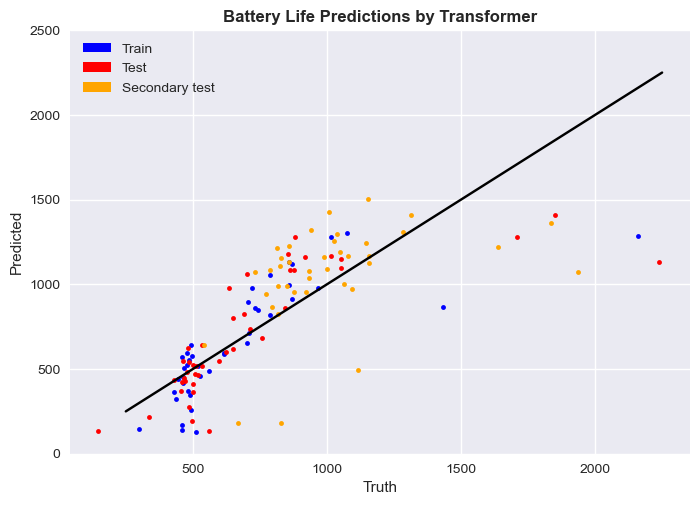

In [436]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label, true_life = cell
        pred = model(input[None,:].to(device)).detach().numpy()[0]
        pred_life = np.power(np.exp(-pred[0])*(0.2-pred[2]),1/pred[1])
        #true_life = np.power(np.exp(-label[0])*(0.2-label[2]),1/label[1])

        predicted.append(pred_life)
        labels.append(true_life[0])
    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_ylim([0,2500])
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)

## Second round of training (calc loss w/ cycle lifetime)

In [439]:
# low learning rate and many epochs for fine-tuning
lr_fine = 5e-4
optimizer_fine = torch.optim.Adam(model.parameters(), lr=lr_fine)
nepoch = 5000
criterion = nn.MSELoss().to(device)

In [440]:
# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer_fine.zero_grad()
        train_input, train_label, true_life = batch
        output = model(train_input.to(device))

        # calculate lifetime using closed-form equation
        pred_life = torch.pow(torch.exp(-output[:,0])*(0.2-output[:,2]),1/output[:,1])
        #true_life = torch.pow(torch.exp(-train_label[:,0])*(0.2-train_label[:,2]),1/train_label[:,1])
        if torch.isnan(pred_life): 
            #print(output)
            break

        #loss = criterion(output, train_label)
        loss = criterion(pred_life,true_life)
        total_loss_train += loss.item()

        loss.backward()
        optimizer_fine.step()

    for cell in test_batched:
        test_input, test_label, true_life = cell
        test_output = model(test_input.to(device))
        #test_loss = criterion(test_output, test_label)
        pred_life = torch.pow(torch.exp(-test_output[:,0])*(0.2-test_output[:,2]),1/test_output[:,1])
        #true_life = torch.pow(torch.exp(-test_label[:,0])*(0.2-test_label[:,2]),1/test_label[:,1])

        test_loss = criterion(pred_life,true_life)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label, true_life = cell
        stest_output = model(stest_input.to(device))
        #stest_loss = criterion(stest_output, stest_label)

        pred_life = torch.pow(torch.exp(-stest_output[:,0])*(0.2-stest_output[:,2]),1/stest_output[:,1])
        #true_life = torch.pow(torch.exp(-stest_label[:,0])*(0.2-stest_label[:,2]),1/stest_label[:,1])

        stest_loss = criterion(pred_life,true_life)
        
        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%100 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

Epochs: 100 | rmse:  230.097 | rmse_test:  256.081 | rmse_stest:  285.375
Epochs: 200 | rmse:  227.297 | rmse_test:  251.395 | rmse_stest:  282.999
Epochs: 300 | rmse:  224.243 | rmse_test:  254.590 | rmse_stest:  282.525
Epochs: 400 | rmse:  221.184 | rmse_test:  252.150 | rmse_stest:  279.330
Epochs: 500 | rmse:  224.594 | rmse_test:  252.066 | rmse_stest:  278.845
Epochs: 600 | rmse:  222.192 | rmse_test:  254.066 | rmse_stest:  280.380
Epochs: 700 | rmse:  219.438 | rmse_test:  253.663 | rmse_stest:  279.330
Epochs: 800 | rmse:  222.471 | rmse_test:  251.351 | rmse_stest:  278.724
Epochs: 900 | rmse:  221.787 | rmse_test:  252.798 | rmse_stest:  277.952
Epochs: 1000 | rmse:  220.344 | rmse_test:  251.779 | rmse_stest:  277.512
Epochs: 1100 | rmse:  221.540 | rmse_test:  251.504 | rmse_stest:  277.265
Epochs: 1200 | rmse:  219.966 | rmse_test:  254.316 | rmse_stest:  278.858
Epochs: 1300 | rmse:  222.654 | rmse_test:  252.458 | rmse_stest:  276.554
Epochs: 1400 | rmse:  225.375 | rm

KeyboardInterrupt: 

246.46268026657359
299.93895294348124
308.1385005354078


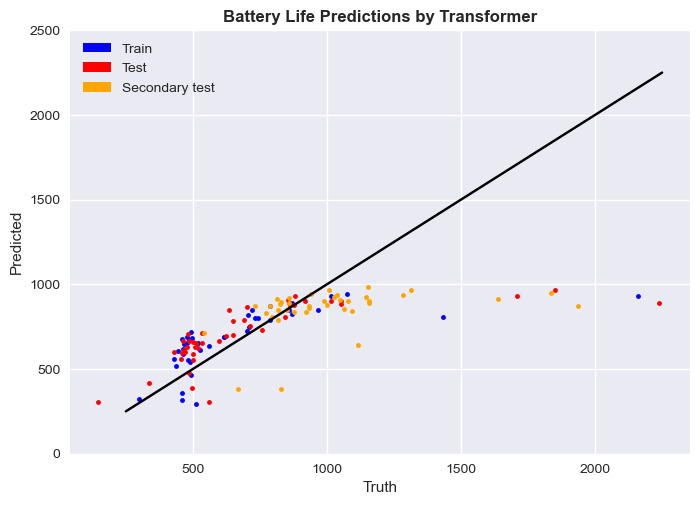

In [433]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label, true_life = cell
        pred = model(input[None,:].to(device)).detach().numpy()[0]
        pred_life = np.power(np.exp(-pred[0])*(0.2-pred[2]),1/pred[1])
        #true_life = np.power(np.exp(-label[0])*(0.2-label[2]),1/label[1])

        predicted.append(pred_life)
        labels.append(true_life[0])
    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_ylim([0,2500])
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
plt.savefig('greaterror.png')